In [1]:
from datascience import *
%matplotlib inline
path_data = '../../../assets/data/'
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)


## Randomized Controlled Experiment

In [2]:
rct = Table.read_table('bta.csv')
rct.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [3]:
rct.pivot('Result', 'Group')

Group,0,1
Control,14,2
Treatment,6,9


In [4]:
rct.group('Group', np.average) #This is also a proportion in this case

Group,Result average
Control,0.125
Treatment,0.6


In [5]:
#This, at first glance, immediately says that 60% > 12.5% 
#Treatment group is better

#However, here comes the role of data science.
#The group was assigned by chance. There may have been some people
#who may have gotten better anyway.
#They must have gotten into the treatment group

#Hence, we've to clear of our hypotheses

In [6]:
observed_outcomes = Table.read_table('observed_outcomes.csv')
observed_outcomes.show()

Group,Outcome if assigned treatment,Outcome if assigned control
Control,Unknown,1
Control,Unknown,1
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0


## Test Statistic

### potential treatment proportion - potential control proportion

In [7]:
group_proportions = rct.group('Group', np.average).column(1)
group_proportions

array([0.125, 0.6  ])

In [8]:
group_proportions.item(1) - group_proportions.item(0) 

0.475

## Simulating the Statistic Under the Null

In [9]:
rct

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [10]:
#array of shuffled labels
#shuffled_labels = rct.sample(with_replacement=False).column('Group')
shuffled_labels = rct.sample(with_replacement=False)[0]
shuffled_labels

#default sample size is the number of rows in the table

array(['Treatment', 'Control', 'Treatment', 'Treatment', 'Treatment',
       'Control', 'Treatment', 'Control', 'Control', 'Control',
       'Treatment', 'Control', 'Control', 'Treatment', 'Control',
       'Treatment', 'Treatment', 'Control', 'Treatment', 'Treatment',
       'Control', 'Control', 'Treatment', 'Control', 'Control',
       'Treatment', 'Control', 'Treatment', 'Treatment', 'Control',
       'Control'], dtype='<U9')

In [11]:
original_and_shuffled = rct.with_column('Shuffled Label', shuffled_labels)
original_and_shuffled.show()

Group,Result,Shuffled Label
Control,1,Treatment
Control,1,Control
Control,0,Treatment
Control,0,Treatment
Control,0,Treatment
Control,0,Control
Control,0,Treatment
Control,0,Control
Control,0,Control
Control,0,Control


In [12]:
original_and_shuffled.select('Result', 'Group').group(
    'Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


In [13]:
original_and_shuffled.select('Result', 'Shuffled Label').group(
    'Shuffled Label', np.average)

Shuffled Label,Result average
Control,0.375
Treatment,0.333333


In [14]:
def difference_of_proportions(table, group_label):
    
    #table with the two relevant columns
    reduced = table.select('Result', group_label)
    
    #table containing group means
    proportions_table = reduced.group(group_label, np.average)
    
    #array of group means
    proportions = proportions_table.column('Result average')
    
    return proportions.item(1) - proportions.item(0)
    

In [15]:
observed_diff = difference_of_proportions(rct, 'Group')
observed_diff

0.475

In [16]:
def one_simulated_difference_of_proportions():
    
    #array of shuffled labels
    shuffled_labels = rct.sample(with_replacement=False).column('Group')
    
    #table of numerical variable and shuffled labels
    shuffled_table = rct.select('Result').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_proportions(shuffled_table, 'Shuffled Label')

In [17]:
one_simulated_difference_of_proportions()

-0.041666666666666685

In [18]:
simulated_diffs = make_array()
for i in np.arange(20000):
    sim_diff = one_simulated_difference_of_proportions()
    simulated_diffs = np.append(simulated_diffs, sim_diff)

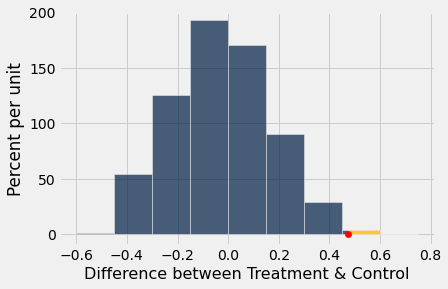

In [19]:
col_name = 'Difference between Treatment & Control'
Table().with_column(col_name, simulated_diffs).hist(
    bins=np.arange(-0.6, 0.81, 0.15), left_end=observed_diff)

plt.ylim(-0.1, 2)
plt.scatter(observed_diff, 0, color='red', s=40, zorder=3)

In [20]:
#p-value
sum(simulated_diffs >= observed_diff)/len(simulated_diffs)

0.0066

In [21]:
#Hence, it favours the alternative hypothesis

In [22]:
#Conclusion also is causal due to RANDOMIZED CONTROLLED TRIALS

In [23]:
#RCT is a way of collecting samples
#A/B Test is a test 

In [24]:
#HOWEVER,
#It is only a conclusion about the 31 patients in the study

In [25]:
#===========================================
#To make conclusions in greater generality, more and larger studies are needed.
#=============================================================================

In [26]:
#See the textbook

## Discussion Question 1

In [27]:
#One row complained about low scored.
#GIS said it could just be chance.
#Can we check

In [28]:
#One row per student

In [29]:
scores = Table().read_table('scores_by_section.csv').relabeled(1, 'Score')
scores

Section,Score
1,22
2,12
2,23
2,14
1,20
3,25
4,19
1,24
5,8
6,14


In [30]:
#max
max(scores.column('Score'))

25

In [31]:
np.average(scores.column('Score'))

15.493036211699165

In [32]:
#table with Section and count in section
section_counts = scores.group('Section')
section_counts.show()

Section,count
1,32
2,32
3,27
4,30
5,33
6,32
7,24
8,29
9,30
10,34


In [33]:
section_averages = scores.group('Section', np.average)
section_averages

Section,Score average
1,15.5938
2,15.125
3,13.6667
4,14.7667
5,17.4545
6,15.0312
7,16.625
8,16.3103
9,14.5667
10,15.2353


In [34]:
section_data = section_counts.join('Section', section_averages, 'Section')
section_data

Section,count,Score average
1,32,15.5938
2,32,15.125
3,27,13.6667
4,30,14.7667
5,33,17.4545
6,32,15.0312
7,24,16.625
8,29,16.3103
9,30,14.5667
10,34,15.2353


### Null Hypothesis : Scores in Section3 are like a simple(without replacement) random sample from all 359 scores

### Alternative Hypothesis : Scores in Section 3 are too low for the null to be true

### Test Statistic : tvd not used because alternative specifies distance
### USE difference

### Test Statistic Better : The average scores generated for Section3



In [35]:
observed_average = 13.6667

In [36]:
def one_simulated_average():
    random_sample = scores.sample(27, with_replacement=False)
    #Randomly sampling 27 scores because 27 = sizeof(Section3)
    #We are going to draw a simulated section3 at random
    return np.average(random_sample.column('Score'))

In [37]:
num_simulations = 50000
averages = make_array()
for i in np.arange(num_simulations):
    averages = np.append(averages, one_simulated_average())

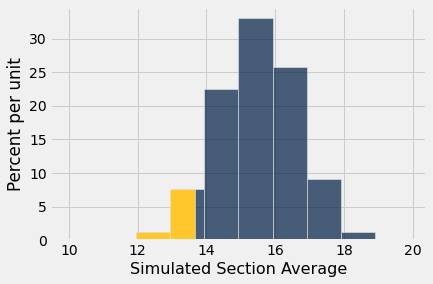

In [38]:
Table().with_column('Simulated Section Average', averages).hist(right_end=observed_average)

Text(0.5, 1.0, 'Prediction Under the Null')

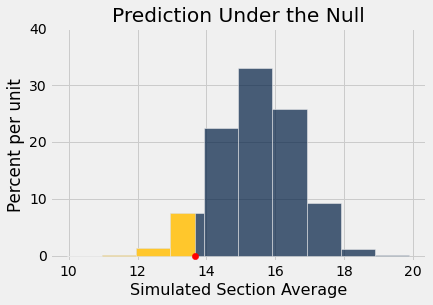

In [39]:
Table().with_column('Simulated Section Average', averages).hist(right_end=observed_average)
plt.ylim(-0.01, 0.4)
plt.scatter(observed_average, 0, color='red', s=40, zorder=3)
plt.title("Prediction Under the Null")

In [40]:
np.count_nonzero(averages <= observed_average)/num_simulations

0.0576

In [41]:
#If using the cutoff of 5%, GSI is right. Consistent with the Null

In [42]:
#Section looks like a random sample